# Colourmap analysis
Live version of this notebook running at: https://colourmapanalysis.pythonanywhere.com/

#### Import required libaries:
- Numpy
- Matplotlib
- Colorspacious

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorspacious import cspace_converter

#### Define function to load a Petrel colourbar (.alut file) and convert to matplotlib ListedColormap

In [4]:
def load_alut(file, name):
    # load Petrel colourbar into numpy array
    cbar = np.loadtxt(file, delimiter=',')
    # remove alpha values
    cbar = cbar[:,0:3]
    # make new matplotlib colourbar - convert 0-255 values to 0-1
    cmap = ListedColormap(cbar/255, name=name)
    
    return cmap

#### Load .alut file
Here we read in the matplotlib jet colourmap, which I had exported as an alut file earlier.

In [5]:
cmp = load_alut('jet.alut', 'Jet Rainbow')

#### Create 2D ramps for display
- Simple ramp from 0 to 1
- Low amplitude sine wave (to be added onto ramp)

In [6]:
x1 = np.linspace(0, 1, 256)
y1 = np.linspace(0, 1, 100)
X1, Y1 = np.meshgrid(x1, y1)
ramp = X1

waves = Y1 * np.sin(X1 * 300) / 20

#### Use colorspacious package to convert colourbar from RGB to CAM02-UCS
- Calculate lightness profile
- Calculate perceptual delta along colourbar

In [7]:
# Create an equally spaced array from 0 to 1 with 256 samples
x_vals = np.linspace(0.0, 1.0, 256)

# Using that array, extract RGB values for colourmap
rgb = plt.cm.get_cmap(cmp)(x_vals)[:, :3]

# Convert the colormap in CAM02-UCS colorspace.
lab = cspace_converter("sRGB1", "CAM02-UCS")(rgb)
# Extract lightness values
lightness = lab[:, 0]

# Create equally spaced arrays from 0 to 1 for perceptutal deltas
x_vals_delta_1 = np.linspace(0.0, 1.0, 256 - 1)
x_vals_delta_5 = np.linspace(0.0, 1.0, (256 - 1) // 5)

# Calculate perceptual delta between every pair of samples
delta = np.sqrt(np.sum((lab[:-1, :] - lab[1:, :]) ** 2, axis=-1))
# Calcuate mean delta between every 5 samples (smooth out noise created by rounding RGB values for .alut file)
delta_5 = np.mean(delta.reshape(-1,5), axis=1)

#### Create colourbar analysis figure
- Colourbar
- Colourbar with added sine wave
- Lightness profile (points coloured with colourbar)
- Perceptual delta profile (between every sample and smoothed over 5 samples)

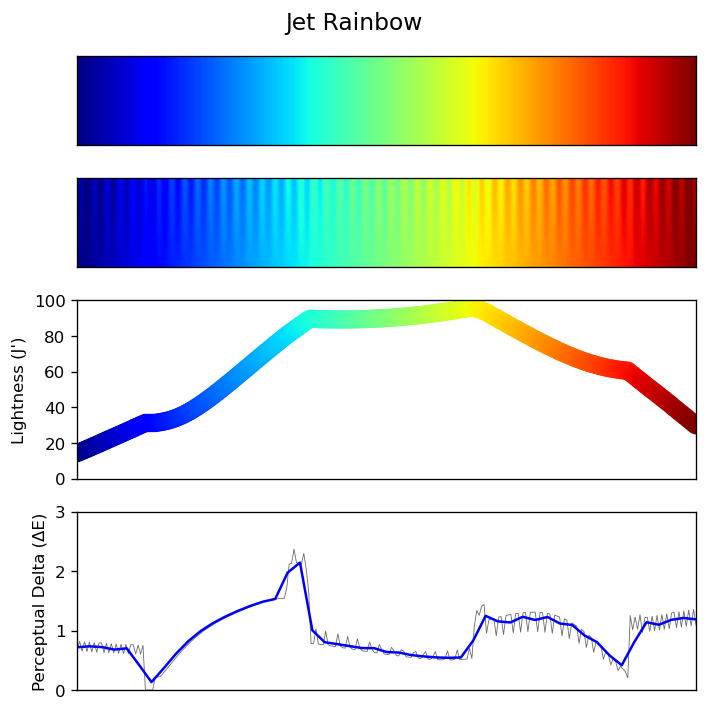

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6,6), dpi=120, gridspec_kw={'height_ratios': (2,2,4,4)})

# Colourbar
ax = axs[0]
ax.imshow(ramp, cmap=cmp, interpolation='bicubic', origin='lower', vmax=1, vmin=0, aspect='auto')
ax.set_xticks([])
ax.set_yticks([])

# Colourbar with added sine wave
ax = axs[1]
ax.imshow(ramp + waves, cmap=cmp, interpolation='bicubic', origin='lower', vmax=1, vmin=0, aspect='auto')
ax.set_xticks([])
ax.set_yticks([])

# Colourbar Lightness plot
ax = axs[2]
ax.scatter(x_vals, lightness, c=x_vals, cmap=cmp, s=100)
ax.set_ylabel("Lightness (J')")
ax.set_ylim([0,100])
ax.set_xlim([0,1])
ax.set_xticks([])

### Perceptual Delta plot
ax = axs[3]
ax.plot(x_vals_delta_1, delta, color='dimgrey', lw=0.5, linestyle='solid')
ax.plot(x_vals_delta_5, delta_5, 'b')
ax.set_ylabel('Perceptual Delta (ΔE)')
ax.set_ylim(0, max(np.max(delta*1.1),3))
ax.set_xlim([0,1])
ax.set_xticks([])

plt.suptitle(cmp.name, fontsize=14)
fig.tight_layout()
plt.show()